In [17]:
import sys
print(sys.version)
print(spark.version)

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]
3.1.3


In [2]:
import os
import time
import subprocess
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [3]:
warnings.filterwarnings(action='ignore')
spark = SparkSession.builder.getOrCreate()

##Add "eagerEval.enabled" to beautify the way Spark DF is displayed
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

## To use legacy casting notation for date
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [4]:
filtered=spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/sirivanth/new_filtered')

23/03/09 02:06:41 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [5]:
filtered.createOrReplaceTempView("filtered")

In [6]:
spark.sql('select created_at from filtered limit 10').toPandas()

,created_at
0,Mon Aug 08 20:46:27 +0000 2022
1,Mon Aug 08 20:46:28 +0000 2022
2,Mon Aug 08 20:46:28 +0000 2022
3,Mon Aug 08 20:46:31 +0000 2022
4,Mon Aug 08 20:46:33 +0000 2022
5,Mon Aug 08 20:46:33 +0000 2022
6,Mon Aug 08 20:46:34 +0000 2022
7,Mon Aug 08 20:46:35 +0000 2022
8,Mon Aug 08 20:46:38 +0000 2022
9,Mon Aug 08 20:46:39 +0000 2022


In [7]:
a = spark.sql('select created_at from filtered')


In [8]:
from pyspark.sql.functions import desc, asc

# Convert the `created_at` column to a DateType
from pyspark.sql.functions import to_date
from pyspark.sql.types import DateType
a = a.withColumn("date", to_date(a["created_at"], "EEE MMM dd HH:mm:ss ZZZZ yyyy").cast(DateType()))

# Extract the day, month, and year from the `date` column
from pyspark.sql.functions import dayofweek, month, year
b = a.withColumn("weekday", dayofweek("date")).withColumn("month", month("date")).withColumn("year", year("date"))

# Find day with highest count
highest_count_day = b.groupBy("weekday", "month", "year").count().orderBy(desc("count")).first()
print("Day with highest count: date={}-{}-{}, count={}".format(highest_count_day['year'], highest_count_day['month'], highest_count_day['weekday'], highest_count_day['count']))

# Find day with lowest count
lowest_count_day = b.groupBy("weekday", "month", "year").count().orderBy(asc("count")).first()
print("Day with lowest count: date={}-{}-{}, count={}".format(lowest_count_day['year'], lowest_count_day['month'], lowest_count_day['weekday'], lowest_count_day['count']))


Day with highest count: date=2022-8-4, count=483749


Day with lowest count: date=2023-2-1, count=49393


In [9]:
from pyspark.sql.functions import desc, asc

# Convert the `created_at` column to a DateType
from pyspark.sql.functions import to_date
from pyspark.sql.types import DateType
a = a.withColumn("date", to_date(a["created_at"], "EEE MMM dd HH:mm:ss ZZZZ yyyy").cast(DateType()))

# Extract the day, month, and year from the `date` column
from pyspark.sql.functions import date_format
b = a.withColumn("day", date_format("date", "dd")).withColumn("month", date_format("date", "MM")).withColumn("year", date_format("date", "yyyy"))

# Find day with highest count
highest_count_day = b.groupBy("day", "month", "year").count().orderBy(desc("count")).first()
print("Day with highest count: date={}-{}-{}, count={}".format(highest_count_day['year'], highest_count_day['month'], highest_count_day['day'], highest_count_day['count']))

# Find day with lowest count
lowest_count_day = b.groupBy("day", "month", "year").count().orderBy(asc("count")).first()
print("Day with lowest count: date={}-{}-{}, count={}".format(lowest_count_day['year'], lowest_count_day['month'], lowest_count_day['day'], lowest_count_day['count']))


Day with highest count: date=2022-08-25, count=143624


Day with lowest count: date=2022-12-25, count=29440


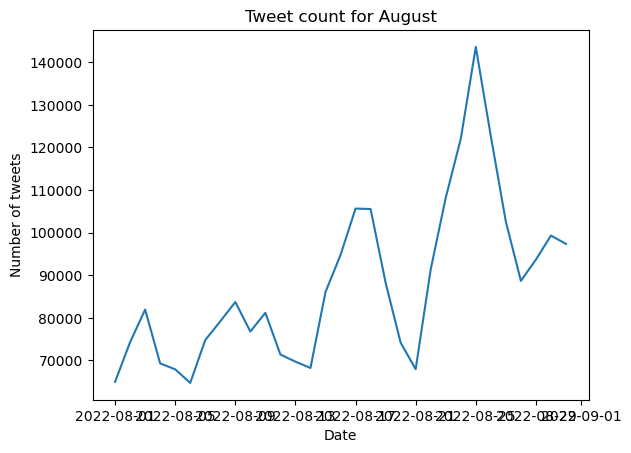

In [11]:
# Convert the `created_at` column to a DateType
from pyspark.sql.functions import to_date
from pyspark.sql.types import DateType
a = a.withColumn("date", to_date(a["created_at"], "EEE MMM dd HH:mm:ss ZZZZ yyyy").cast(DateType()))

# Filter the data to only include tweets from August
from pyspark.sql.functions import month
a_august = a.filter(month("date") == 8)

# Group by date and count number of tweets for each date
from pyspark.sql.functions import count, date_format
august_tweet_count = a_august.groupBy(date_format("date", "yyyy-MM-dd").alias("date")).agg(count("*").alias("tweet_count"))

# Convert the `date` column to a date type
august_tweet_count = august_tweet_count.withColumn("date", to_date(august_tweet_count["date"], "yyyy-MM-dd").cast(DateType()))

# Sort by date
august_tweet_count = august_tweet_count.sort("date")

# Convert to Pandas dataframe for plotting
august_tweet_count_pd = august_tweet_count.toPandas()

# Plot the time series
import matplotlib.pyplot as plt
plt.plot(august_tweet_count_pd["date"], august_tweet_count_pd["tweet_count"])
plt.title("Tweet count for August")
plt.xlabel("Date")
plt.ylabel("Number of tweets")
plt.show()


In [12]:
from pyspark.sql.functions import desc, asc, date_format

# Convert the `created_at` column to a DateType
from pyspark.sql.functions import to_date
from pyspark.sql.types import DateType
a = a.withColumn("date", to_date(a["created_at"], "EEE MMM dd HH:mm:ss ZZZZ yyyy").cast(DateType()))

# Extract the day of the month from the `date` column and format as a string
b = a.withColumn("day", date_format("date", "d"))

# Find day with highest count
highest_count_day = b.groupBy("day").count().orderBy(desc("count")).first()
print("Day with highest count: date={}, count={}".format(highest_count_day['day'], highest_count_day['count']))

# Find day with lowest count
lowest_count_day = b.groupBy("day").count().orderBy(asc("count")).first()
print("Day with lowest count: date={}, count={}".format(lowest_count_day['day'], lowest_count_day['count']))


Day with highest count: date=6, count=885051


Day with lowest count: date=31, count=425869


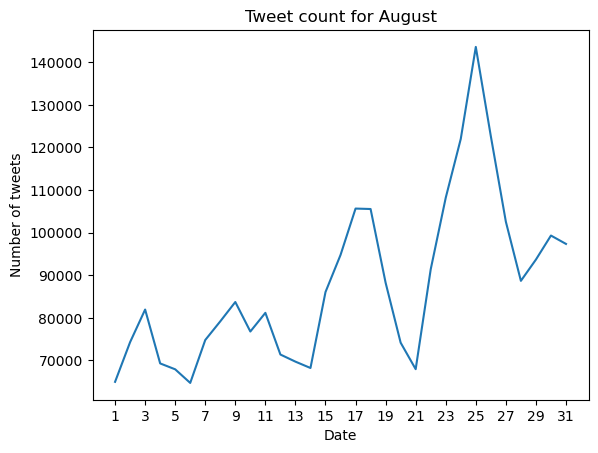

In [16]:
# Plot the time series
import matplotlib.pyplot as plt
plt.plot(august_tweet_count_pd["date"], august_tweet_count_pd["tweet_count"])
plt.title("Tweet count for August")
plt.xlabel("Date")
plt.ylabel("Number of tweets")

# Customize x-axis ticks to show only day numbers
plt.xticks(august_tweet_count_pd["date"][::2], [d.day for d in august_tweet_count_pd["date"][::2]])

plt.show()


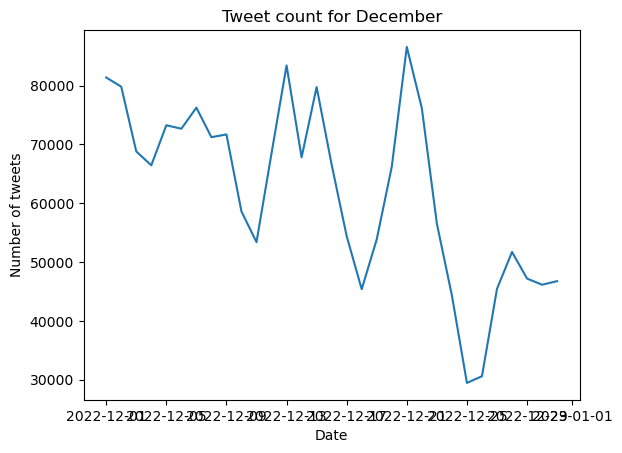

In [19]:
from pyspark.sql.functions import month

# Filter the data to only include tweets from December
a_december = a.filter(month("date") == 12)

# Group by date and count number of tweets for each date
from pyspark.sql.functions import count, date_format
december_tweet_count = a_december.groupBy(date_format("date", "yyyy-MM-dd").alias("date")).agg(count("*").alias("tweet_count"))

# Convert the `date` column to a date type
december_tweet_count = december_tweet_count.withColumn("date", to_date(december_tweet_count["date"], "yyyy-MM-dd").cast(DateType()))

# Sort by date
december_tweet_count = december_tweet_count.sort("date")

# Convert to Pandas dataframe for plotting
december_tweet_count_pd = december_tweet_count.toPandas()

# Plot the time series
import matplotlib.pyplot as plt
plt.plot(december_tweet_count_pd["date"], december_tweet_count_pd["tweet_count"])
plt.title("Tweet count for December")
plt.xlabel("Date")
plt.ylabel("Number of tweets")
plt.show()


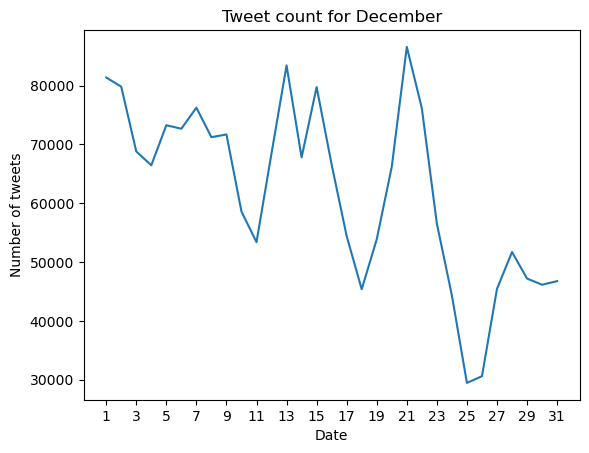

In [20]:
# Plot the time series for December
import matplotlib.pyplot as plt
plt.plot(december_tweet_count_pd["date"], december_tweet_count_pd["tweet_count"])
plt.title("Tweet count for December")
plt.xlabel("Date")
plt.ylabel("Number of tweets")

# Customize x-axis ticks to show only day numbers
plt.xticks(december_tweet_count_pd["date"][::2], [d.day for d in december_tweet_count_pd["date"][::2]])

plt.show()
